In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import requests
import folium 
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans

In [54]:
df = pd.read_csv('neighborhood_dataset.csv')

In [55]:
df.head()

,Unnamed: 0,Borough,Neighborhoods,Latitude,Longitude,Population,City,AverageIncome
0,0,Central,Cantonment area,12.972442,77.580643,866377,Bangalore,18944.099792
1,1,Central,Domlur,12.960992,77.638726,743186,Bangalore,56837.022198
2,2,Central,Indiranagar,12.971891,77.641151,474289,Bangalore,41991.817435
3,3,Central,Jeevanbheemanagar,12.962900,77.659500,527874,Bangalore,6667.447632
4,4,Central,Malleswaram,13.003100,77.564300,893629,Bangalore,53270.063892


In [56]:
df.drop('Unnamed: 0',axis=1,inplace=True)

In [57]:
CLIENT_ID = 'ZK40VO3EPO1ZY5C04PNYSMQH2ZFZ3U1TPL0QME3WEY553DMH'
CLIENT_SECRET = 'RQBRNE2T3OTMYY4BBJ3YWLS0P2FK413O22MQV1QHBHAD04WG'
VERSION = '20180606'
LIMIT = 150

In [58]:
unique_boroughs_of_bangalore = df['Borough'].unique().tolist()

In [59]:
borough_colors ={}
for i in unique_boroughs_of_bangalore:
    borough_colors[i] = '#%02X%02X%02X' % tuple(np.random.choice(range(256),size=3))

In [60]:
bangalore_latitude = df['Latitude'].mean()
bangalore_longitude = df['Longitude'].mean()
print("Latitude and Longitude of Bangalore are : ",bangalore_latitude,bangalore_longitude)

Latitude and Longitude of Bangalore are :  12.962339620312497 77.60175294687502


In [61]:
bangalore_map = folium.Map(location=[bangalore_latitude,bangalore_longitude],zoom_start=12,control_scale=True)

In [62]:
for lat,lng,boro,nei in zip(df['Latitude'],
                           df['Longitude'],
                           df['Borough'],
                           df['Neighborhoods']):
    label_text = boro + ' - ' + nei
    label = folium.Popup(label_text,parse_html=True)
    folium.CircleMarker(
    [lat,lng],
    tooltip = label_text,
    radius = 4,
    popup = label,
    color=borough_colors[boro],
    fill=True,
    fill_color = borough_colors[boro],
    fill_opacity=0.7).add_to(bangalore_map)

In [13]:
bangalore_map

In [63]:
def getNearbyVenues(names, boro, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, boro, lat, lng in zip(names, boro, latitudes, longitudes):
        print("Fetching venues for : ",name)            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            boro,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                             'Borough',
                             'Neighborhood Latitude', 
                             'Neighborhood Longitude', 
                             'Venue', 
                             'Venue Latitude', 
                             'Venue Longitude', 
                             'Venue Category']
    
    return(nearby_venues)

In [64]:
bangalore_venues = getNearbyVenues(names=df['Neighborhoods'],latitudes=df['Latitude'],longitudes=df['Longitude'],boro=df['Borough'])

Fetching venues for :  Cantonment area
Fetching venues for :  Domlur
Fetching venues for :  Indiranagar
Fetching venues for :  Jeevanbheemanagar
Fetching venues for :  Malleswaram
Fetching venues for :  Pete area
Fetching venues for :  Rajajinagar
Fetching venues for :  Sadashivanagar
Fetching venues for :  Seshadripuram
Fetching venues for :  Shivajinagar
Fetching venues for :  Ulsoor
Fetching venues for :  Vasanth Nagar
Fetching venues for :  Bellandur
Fetching venues for :  CV Raman Nagar
Fetching venues for :  Hoodi
Fetching venues for :  Krishnarajapuram
Fetching venues for :  Mahadevapura
Fetching venues for :  Marathahalli
Fetching venues for :  Varthur
Fetching venues for :  Whitefield
Fetching venues for :  Banaswadi
Fetching venues for :  HBR Layout
Fetching venues for :  Horamavu
Fetching venues for :  Kammanahalli
Fetching venues for :  Lingarajapuram
Fetching venues for :  Ramamurthy Nagar
Fetching venues for :  Hebbal
Fetching venues for :  Jalahalli
Fetching venues for :

In [65]:
print("Total number of venues found in Bangalore are : ",bangalore_venues.shape[0])

Total number of venues found in Bangalore are :  591


In [66]:
bangalore_venues.head(5)

,Neighborhood,Borough,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Cantonment area,Central,12.972442,77.580643,Hotel Fishland,12.975569,77.578592,Seafood Restaurant
1,Cantonment area,Central,12.972442,77.580643,Vasudev Adigas,12.973707,77.579257,Indian Restaurant
2,Cantonment area,Central,12.972442,77.580643,Sapna Book House,12.976355,77.578461,Bookstore
3,Cantonment area,Central,12.972442,77.580643,Adigas Hotel,12.973554,77.579161,Restaurant
4,Cantonment area,Central,12.972442,77.580643,Kamat Yatrinivas,12.975985,77.578125,Indian Restaurant


In [67]:
bangalore_venues.groupby('Venue Category').count()['Neighborhood'].sort_values(ascending=False).head(10)

Venue Category
Indian Restaurant       114
Café                     33
Bakery                   27
Fast Food Restaurant     27
Ice Cream Shop           22
Pizza Place              18
Department Store         18
Coffee Shop              15
Chinese Restaurant       15
Restaurant               12
Name: Neighborhood, dtype: int64

In [68]:
print("Total number of unique categories in bangalore are : ",len(bangalore_venues['Venue Category'].unique()))

Total number of unique categories in bangalore are :  128


In [69]:
individual_bangalore_venue_count = bangalore_venues.groupby(['Borough','Neighborhood'])['Borough'].count().to_frame()

In [70]:
individual_bangalore_venue_count

Borough
Borough         Neighborhood                 
Central         Cantonment area             6
                Domlur                     14
                Indiranagar                64
                Jeevanbheemanagar           4
                Malleswaram                 7
                Pete area                   4
                Rajajinagar                 9
                Sadashivanagar             22
                Seshadripuram               8
                Shivajinagar               12
                Ulsoor                      4
                Vasanth Nagar              24
Eastern         Bellandur                  22
                CV Raman Nagar              7
                Hoodi                       4
                Krishnarajapuram            2
                Mahadevapura                5
                Marathahalli                7
                Varthur                     1
                Whitefield                 10
NorthEastern    Banaswadi                   4
                HBR Layout                  4
                Horamavu                    2
                Kammanahalli               11
                Lingarajapuram              1
                Ramamurthy Nagar            4
Northern        Hebbal                      7
                Jalahalli                   3
                Mathikere                  13
                R. T. Nagar                 9
                Yelahanka                   5
                Yeshwanthpur                9
SouthEastern    BTM Layout                 35
                Bommanahalli                4
                Electronic City             5
                HSR Layout                  8
                Koramangala                 7
                Madiwala                   30
Southern        Banashankari               12
                Basavanagudi               11
                Girinagar                   3
                J. P. Nagar                25
                Jayanagar                  16
                Kumaraswamy Layout         12
                Padmanabhanagar             4
                Uttarahalli                12
SouthernSuburbs Anjanapura                  1
                Arekere                    24
                Begur                       4
                Gottigere                   5
                Hulimavu                    4
                Kothnur                     5
Western         Basaveshwaranagar          19
                Kamakshipalya               1
                Kengeri                     5
                Mahalakshmi Layout         11
                Nagarbhavi                  5
                Nayandahalli                5
                Rajarajeshwari Nagar        6
                Vijayanagar                 4

In [71]:
individual_bangalore_venue_count.rename(columns={'Borough':'NumberOfVenues'},inplace=True)

In [72]:
individual_bangalore_venue_count.reset_index(inplace=True)

In [73]:
individual_bangalore_venue_count

,Borough,Neighborhood,NumberOfVenues
0,Central,Cantonment area,6
1,Central,Domlur,14
2,Central,Indiranagar,64
3,Central,Jeevanbheemanagar,4
4,Central,Malleswaram,7
5,Central,Pete area,4
6,Central,Rajajinagar,9
7,Central,Sadashivanagar,22
8,Central,Seshadripuram,8
9,Central,Shivajinagar,12


[Text(0,0,'Cantonment area'),
 Text(0,0,'Domlur'),
 Text(0,0,'Indiranagar'),
 Text(0,0,'Jeevanbheemanagar'),
 Text(0,0,'Malleswaram'),
 Text(0,0,'Pete area'),
 Text(0,0,'Rajajinagar'),
 Text(0,0,'Sadashivanagar'),
 Text(0,0,'Seshadripuram'),
 Text(0,0,'Shivajinagar'),
 Text(0,0,'Ulsoor'),
 Text(0,0,'Vasanth Nagar'),
 Text(0,0,'Bellandur'),
 Text(0,0,'CV Raman Nagar'),
 Text(0,0,'Hoodi'),
 Text(0,0,'Krishnarajapuram'),
 Text(0,0,'Mahadevapura'),
 Text(0,0,'Marathahalli'),
 Text(0,0,'Varthur'),
 Text(0,0,'Whitefield'),
 Text(0,0,'Banaswadi'),
 Text(0,0,'HBR Layout'),
 Text(0,0,'Horamavu'),
 Text(0,0,'Kammanahalli'),
 Text(0,0,'Lingarajapuram'),
 Text(0,0,'Ramamurthy Nagar'),
 Text(0,0,'Hebbal'),
 Text(0,0,'Jalahalli'),
 Text(0,0,'Mathikere'),
 Text(0,0,'R. T. Nagar'),
 Text(0,0,'Yelahanka'),
 Text(0,0,'Yeshwanthpur'),
 Text(0,0,'BTM Layout'),
 Text(0,0,'Bommanahalli'),
 Text(0,0,'Electronic City'),
 Text(0,0,'HSR Layout'),
 Text(0,0,'Koramangala'),
 Text(0,0,'Madiwala'),
 Text(0,0,'Banas

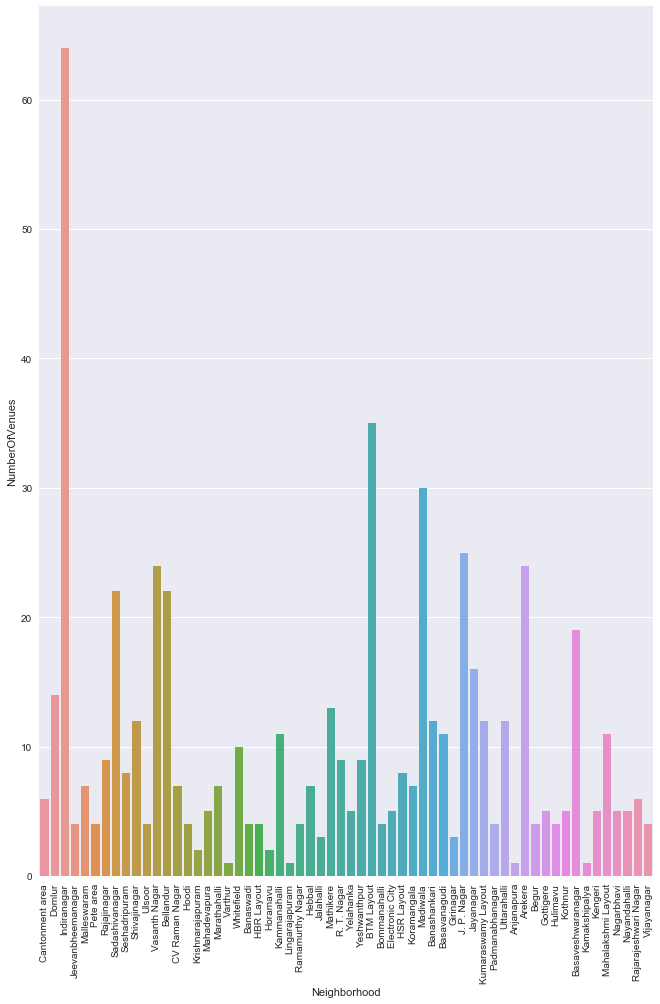

In [74]:
sns.set(rc={'figure.figsize':(11,16)})
plot = sns.barplot(x='Neighborhood',y='NumberOfVenues',data=individual_bangalore_venue_count)
plot.set_xticklabels(individual_bangalore_venue_count['Neighborhood'],rotation=90)

In [75]:
bangalore_venues[bangalore_venues['Neighborhood']=='Whitefield']

,Neighborhood,Borough,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
226,Whitefield,Eastern,12.9698,77.7499,Herbs and Spices,12.968145,77.750862,Eastern European Restaurant
227,Whitefield,Eastern,12.9698,77.7499,Golds Gym,12.972217,77.750529,Gym / Fitness Center
228,Whitefield,Eastern,12.9698,77.7499,Chef Baker's,12.969730,77.751302,Bakery
229,Whitefield,Eastern,12.9698,77.7499,Royal Orchid Suites,12.966774,77.751262,Hotel
230,Whitefield,Eastern,12.9698,77.7499,The river side bar and kitchen,12.967298,77.749614,Hotel Bar
231,Whitefield,Eastern,12.9698,77.7499,Stoner,12.968464,77.749499,Ice Cream Shop
232,Whitefield,Eastern,12.9698,77.7499,Punjabi Kitchen,12.968100,77.749804,Diner
233,Whitefield,Eastern,12.9698,77.7499,Fabindia,12.972156,77.750447,Market
234,Whitefield,Eastern,12.9698,77.7499,refresh,12.965621,77.749234,Café
235,Whitefield,Eastern,12.9698,77.7499,Cheenavala,12.966435,77.749368,Kerala Restaurant


In [76]:
bangalore_venues_onehot = pd.get_dummies(bangalore_venues[['Venue Category']])

In [77]:
bangalore_venues_onehot

,Venue Category_ATM,Venue Category_Accessories Store,Venue Category_Andhra Restaurant,Venue Category_Art Museum,Venue Category_Arts & Crafts Store,Venue Category_Asian Restaurant,Venue Category_Athletics & Sports,Venue Category_Auto Garage,Venue Category_BBQ Joint,Venue Category_Badminton Court,...,Venue Category_Supermarket,Venue Category_Tea Room,Venue Category_Tex-Mex Restaurant,Venue Category_Toll Plaza,Venue Category_Train Station,Venue Category_Udupi Restaurant,Venue Category_Vegetarian / Vegan Restaurant,Venue Category_Vietnamese Restaurant,Venue Category_Women's Store,Venue Category_Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [78]:
bangalore_venues_onehot['Neighborhood'] = bangalore_venues['Neighborhood']
bangalore_venues_grouped = bangalore_venues_onehot.groupby('Neighborhood').mean().reset_index()
bangalore_venues_grouped

,Neighborhood,Venue Category_ATM,Venue Category_Accessories Store,Venue Category_Andhra Restaurant,Venue Category_Art Museum,Venue Category_Arts & Crafts Store,Venue Category_Asian Restaurant,Venue Category_Athletics & Sports,Venue Category_Auto Garage,Venue Category_BBQ Joint,...,Venue Category_Supermarket,Venue Category_Tea Room,Venue Category_Tex-Mex Restaurant,Venue Category_Toll Plaza,Venue Category_Train Station,Venue Category_Udupi Restaurant,Venue Category_Vegetarian / Vegan Restaurant,Venue Category_Vietnamese Restaurant,Venue Category_Women's Store,Venue Category_Yoga Studio
0,Anjanapura,1.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
1,Arekere,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.041667,0.0,0.000000,...,0.041667,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
2,BTM Layout,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.057143,0.000000,0.000000,0.00
3,Banashankari,0.0,0.083333,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
4,Banaswadi,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.250000,0.000000,0.000000,0.00
5,Basavanagudi,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
6,Basaveshwaranagar,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
7,Begur,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000,...,0.250000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
8,Bellandur,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000,...,0.000000,0.045455,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
9,Bommanahalli,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00


In [79]:
number_of_top_venues = 5
for hood in bangalore_venues_grouped['Neighborhood']:
    print('---------',hood,'---------')
    temp = bangalore_venues_grouped[bangalore_venues_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['Venue','Frequency']
    temp = temp.iloc[1:]
    temp['Frequency'] = temp['Frequency'].astype(float)
    temp = temp.round({'Frequency': 2})
    print(temp.sort_values('Frequency', ascending=False).reset_index(drop=True).head(number_of_top_venues))
    print('\n')

--------- Anjanapura ---------
                                          Venue  Frequency
0                            Venue Category_ATM        1.0
1              Venue Category_Accessories Store        0.0
2                           Venue Category_Park        0.0
3  Venue Category_Paper / Office Supplies Store        0.0
4                Venue Category_Paintball Field        0.0


--------- Arekere ---------
                                 Venue  Frequency
0     Venue Category_Indian Restaurant       0.17
1   Venue Category_Sporting Goods Shop       0.12
2           Venue Category_Pizza Place       0.08
3           Venue Category_Supermarket       0.04
4  Venue Category_Fast Food Restaurant       0.04


--------- BTM Layout ---------
                               Venue  Frequency
0   Venue Category_Indian Restaurant       0.20
1         Venue Category_Snack Place       0.09
2      Venue Category_Ice Cream Shop       0.09
3      Venue Category_Sandwich Place       0.06
4  Venue Cat

4   Venue Category_Asian Restaurant       0.06


--------- Jeevanbheemanagar ---------
                                 Venue  Frequency
0  Venue Category_Fast Food Restaurant       0.50
1           Venue Category_Pizza Place       0.25
2    Venue Category_Chinese Restaurant       0.25
3       Venue Category_Motorcycle Shop       0.00
4                  Venue Category_Park       0.00


--------- Kamakshipalya ---------
                                          Venue  Frequency
0                            Venue Category_ATM        1.0
1              Venue Category_Accessories Store        0.0
2                           Venue Category_Park        0.0
3  Venue Category_Paper / Office Supplies Store        0.0
4                Venue Category_Paintball Field        0.0


--------- Kammanahalli ---------
                                 Venue  Frequency
0  Venue Category_Fast Food Restaurant       0.18
1           Venue Category_Snack Place       0.09
2     Venue Category_Korean Restaurant

                               Venue  Frequency
0   Venue Category_Indian Restaurant       0.21
1         Venue Category_Coffee Shop       0.17
2  Venue Category_Italian Restaurant       0.08
3               Venue Category_Hotel       0.08
4  Venue Category_Chinese Restaurant       0.08


--------- Vijayanagar ---------
                                Venue  Frequency
0               Venue Category_Bakery       0.50
1    Venue Category_Indian Restaurant       0.25
2  Venue Category_Arts & Crafts Store       0.25
3                  Venue Category_ATM       0.00
4        Venue Category_Movie Theater       0.00


--------- Whitefield ---------
                              Venue  Frequency
0             Venue Category_Bakery        0.1
1  Venue Category_Kerala Restaurant        0.1
2               Venue Category_Café        0.1
3              Venue Category_Diner        0.1
4     Venue Category_Ice Cream Shop        0.1


--------- Yelahanka ---------
                             Venue  F

In [32]:
def return_most_common_venues(row, number_of_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:number_of_top_venues]

In [33]:
number_of_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(number_of_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = bangalore_venues_grouped['Neighborhood']

for ind in np.arange(bangalore_venues_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bangalore_venues_grouped.iloc[ind, :], number_of_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Anjanapura,Venue Category_ATM,Venue Category_Women's Store,Venue Category_Cupcake Shop,Venue Category_Deli / Bodega,Venue Category_Department Store,Venue Category_Dessert Shop,Venue Category_Dim Sum Restaurant,Venue Category_Diner,Venue Category_Donut Shop,Venue Category_Eastern European Restaurant
1,Arekere,Venue Category_Indian Restaurant,Venue Category_Sporting Goods Shop,Venue Category_Pizza Place,Venue Category_Ice Cream Shop,Venue Category_Mughlai Restaurant,Venue Category_Chinese Restaurant,Venue Category_Fast Food Restaurant,Venue Category_Business Service,Venue Category_Bus Line,Venue Category_Liquor Store
2,BTM Layout,Venue Category_Indian Restaurant,Venue Category_Ice Cream Shop,Venue Category_Snack Place,Venue Category_Sandwich Place,Venue Category_Fast Food Restaurant,Venue Category_Pizza Place,Venue Category_Chinese Restaurant,Venue Category_Bakery,Venue Category_Vegetarian / Vegan Restaurant,Venue Category_Restaurant
3,Banashankari,Venue Category_Café,Venue Category_Indian Restaurant,Venue Category_Clothing Store,Venue Category_Shoe Store,Venue Category_Accessories Store,Venue Category_North Indian Restaurant,Venue Category_Fast Food Restaurant,Venue Category_Pizza Place,Venue Category_Sporting Goods Shop,Venue Category_Falafel Restaurant
4,Banaswadi,Venue Category_Indian Restaurant,Venue Category_Vegetarian / Vegan Restaurant,Venue Category_Bakery,Venue Category_Yoga Studio,Venue Category_Eastern European Restaurant,Venue Category_Flea Market,Venue Category_Fish & Chips Shop,Venue Category_Fast Food Restaurant,Venue Category_Falafel Restaurant,Venue Category_Electronics Store


In [34]:
neighborhoods_venues_sorted.shape

(60, 11)

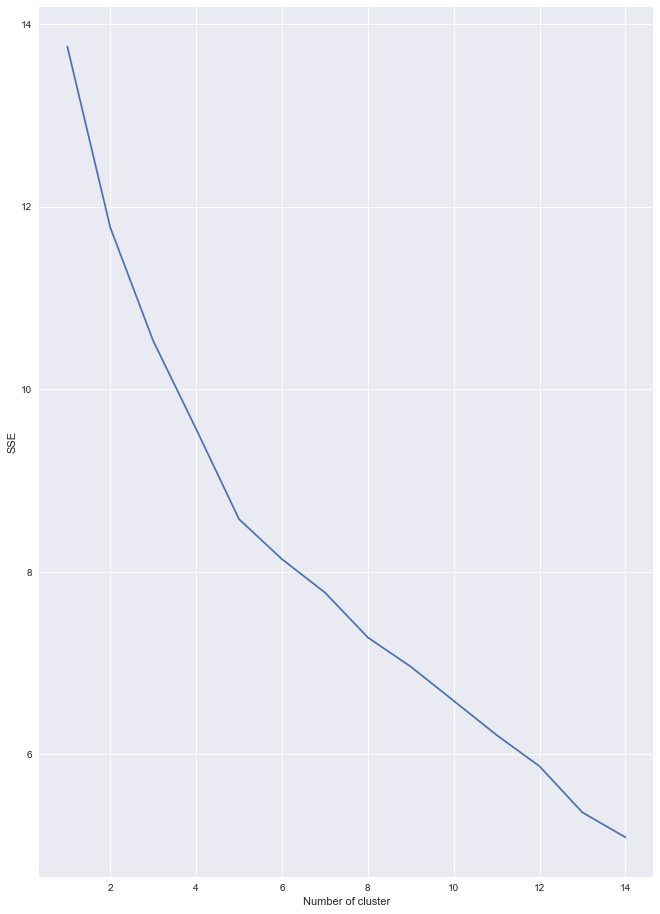

In [35]:
sse = {}
for k in range(1,15):
    kmeans = KMeans(n_clusters=k,random_state=0)
    kmeans.fit(bangalore_venues_grouped.drop('Neighborhood',axis=1))
    bangalore_venues_grouped['Cluster'] = kmeans.labels_
    sse[k] = kmeans.inertia_

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [36]:
kmeans = KMeans(n_clusters=5,random_state=0)

In [37]:
kmeans.fit(bangalore_venues_grouped.drop('Neighborhood',axis=1))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [38]:
bangalore_venues_grouped['Cluster'] = kmeans.labels_

In [39]:
bangalore_venues_grouped.groupby('Cluster')['Neighborhood'].count()

Cluster
0     4
1    21
2    18
3    10
4     7
Name: Neighborhood, dtype: int64

In [40]:
bangalore_venues_grouped.columns

Index(['Neighborhood', 'Venue Category_ATM',
       'Venue Category_Accessories Store', 'Venue Category_Andhra Restaurant',
       'Venue Category_Art Museum', 'Venue Category_Arts & Crafts Store',
       'Venue Category_Asian Restaurant', 'Venue Category_Athletics & Sports',
       'Venue Category_Auto Garage', 'Venue Category_BBQ Joint',
       ...
       'Venue Category_Tea Room', 'Venue Category_Tex-Mex Restaurant',
       'Venue Category_Toll Plaza', 'Venue Category_Train Station',
       'Venue Category_Udupi Restaurant',
       'Venue Category_Vegetarian / Vegan Restaurant',
       'Venue Category_Vietnamese Restaurant', 'Venue Category_Women's Store',
       'Venue Category_Yoga Studio', 'Cluster'],
      dtype='object', length=130)

In [41]:
neighborhoods_venues_sorted = neighborhoods_venues_sorted.merge(bangalore_venues_grouped,on='Neighborhood')

In [42]:
neighborhoods_venues_sorted.head(4)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,...,Venue Category_Tea Room,Venue Category_Tex-Mex Restaurant,Venue Category_Toll Plaza,Venue Category_Train Station,Venue Category_Udupi Restaurant,Venue Category_Vegetarian / Vegan Restaurant,Venue Category_Vietnamese Restaurant,Venue Category_Women's Store,Venue Category_Yoga Studio,Cluster
0,Anjanapura,Venue Category_ATM,Venue Category_Women's Store,Venue Category_Cupcake Shop,Venue Category_Deli / Bodega,Venue Category_Department Store,Venue Category_Dessert Shop,Venue Category_Dim Sum Restaurant,Venue Category_Diner,Venue Category_Donut Shop,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,2
1,Arekere,Venue Category_Indian Restaurant,Venue Category_Sporting Goods Shop,Venue Category_Pizza Place,Venue Category_Ice Cream Shop,Venue Category_Mughlai Restaurant,Venue Category_Chinese Restaurant,Venue Category_Fast Food Restaurant,Venue Category_Business Service,Venue Category_Bus Line,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1
2,BTM Layout,Venue Category_Indian Restaurant,Venue Category_Ice Cream Shop,Venue Category_Snack Place,Venue Category_Sandwich Place,Venue Category_Fast Food Restaurant,Venue Category_Pizza Place,Venue Category_Chinese Restaurant,Venue Category_Bakery,Venue Category_Vegetarian / Vegan Restaurant,...,0.0,0.0,0.0,0.0,0.0,0.057143,0.0,0.0,0.0,1
3,Banashankari,Venue Category_Café,Venue Category_Indian Restaurant,Venue Category_Clothing Store,Venue Category_Shoe Store,Venue Category_Accessories Store,Venue Category_North Indian Restaurant,Venue Category_Fast Food Restaurant,Venue Category_Pizza Place,Venue Category_Sporting Goods Shop,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,3


In [43]:
neighborhoods_venues_sorted.columns
neighborhoods_venues_sorted = neighborhoods_venues_sorted.merge(bangalore_venues,on='Neighborhood')

In [44]:
# create map
map_clusters = folium.Map(location=[bangalore_latitude, bangalore_longitude], zoom_start=11)

In [45]:
x = np.arange(6)
ys = [i + x + (i*x)**2 for i in range(6)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(neighborhoods_venues_sorted['Neighborhood Latitude'], neighborhoods_venues_sorted['Neighborhood Longitude'], neighborhoods_venues_sorted['Neighborhood'], neighborhoods_venues_sorted['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       

In [46]:
map_clusters

In [80]:
number_of_top_venues = 5
for hood in bangalore_venues_grouped['Neighborhood']:
    print('---------',hood,'---------')
    temp = bangalore_venues_grouped[bangalore_venues_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['Venue','Frequency']
    temp = temp.iloc[1:]
    temp['Frequency'] = temp['Frequency'].astype(float)
    temp = temp.round({'Frequency': 2})
    print(temp.sort_values('Frequency', ascending=False).reset_index(drop=True).head(number_of_top_venues))
    print('\n')

--------- Anjanapura ---------
                                          Venue  Frequency
0                            Venue Category_ATM        1.0
1              Venue Category_Accessories Store        0.0
2                           Venue Category_Park        0.0
3  Venue Category_Paper / Office Supplies Store        0.0
4                Venue Category_Paintball Field        0.0


--------- Arekere ---------
                                 Venue  Frequency
0     Venue Category_Indian Restaurant       0.17
1   Venue Category_Sporting Goods Shop       0.12
2           Venue Category_Pizza Place       0.08
3           Venue Category_Supermarket       0.04
4  Venue Category_Fast Food Restaurant       0.04


--------- BTM Layout ---------
                               Venue  Frequency
0   Venue Category_Indian Restaurant       0.20
1         Venue Category_Snack Place       0.09
2      Venue Category_Ice Cream Shop       0.09
3      Venue Category_Sandwich Place       0.06
4  Venue Cat

                                Venue  Frequency
0  Venue Category_Indie Movie Theater       0.33
1    Venue Category_Convenience Store       0.33
2           Venue Category_Playground       0.33
3      Venue Category_Motorcycle Shop       0.00
4                 Venue Category_Park       0.00


--------- Jayanagar ---------
                              Venue  Frequency
0  Venue Category_Indian Restaurant       0.38
1             Venue Category_Bakery       0.12
2        Venue Category_Flea Market       0.06
3   Venue Category_Department Store       0.06
4   Venue Category_Asian Restaurant       0.06


--------- Jeevanbheemanagar ---------
                                 Venue  Frequency
0  Venue Category_Fast Food Restaurant       0.50
1           Venue Category_Pizza Place       0.25
2    Venue Category_Chinese Restaurant       0.25
3       Venue Category_Motorcycle Shop       0.00
4                  Venue Category_Park       0.00


--------- Kamakshipalya ---------
                

                              Venue  Frequency
0  Venue Category_Indian Restaurant       0.25
1  Venue Category_Food & Drink Shop       0.12
2             Venue Category_Lounge       0.12
3   Venue Category_Asian Restaurant       0.12
4        Venue Category_Chaat Place       0.12


--------- Shivajinagar ---------
                                    Venue  Frequency
0        Venue Category_Indian Restaurant       0.42
1           Venue Category_Clothing Store       0.17
2  Venue Category_South Indian Restaurant       0.08
3                   Venue Category_Market       0.08
4     Venue Category_Fast Food Restaurant       0.08


--------- Ulsoor ---------
                         Venue  Frequency
0          Venue Category_Café       0.50
1        Venue Category_Bakery       0.25
2  Venue Category_Burger Joint       0.25
3           Venue Category_ATM       0.00
4     Venue Category_Nightclub       0.00


--------- Uttarahalli ---------
                              Venue  Frequency
0  

# Conclusion
 From the output of the above cell we can see whether any restaurants are present are in the neighborhood or not and what are the kind of restaurants are present.
For example, in Anjanapur there are no restaurants and in HSR Layout there is no Indian restaurant